In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

from helper_funcs import *

In [10]:
zipdata = get_zipdata()
zipdata.shape

----pulling ZipCode data from Azure storage----
----Done----


(6987, 43)

#### Fill the following columns with 0 for NaN values

In [11]:
zipdata.loc[zipdata.over_65_ratio.isna(),'over_65_ratio'] = 0
zipdata.loc[zipdata.Hosp_count.isna(),'Hosp_count'] = 0
zipdata.loc[zipdata.HPI.isna(),'HPI'] = 0
zipdata.loc[zipdata.Demand_score.isna(),'Demand_score'] = 0
zipdata.loc[zipdata.Supply_score.isna(),'Supply_score'] = 0
zipdata.loc[zipdata.listviews_vs_US.isna(),'listviews_vs_US'] = 0
zipdata.loc[zipdata.med_days_on_mkt.isna(),'med_days_on_mkt'] = 0
zipdata.loc[zipdata.nielson_rank.isna(),'nielson_rank'] = 0
zipdata.loc[zipdata.Zillow_HVF.isna(),'Zillow_HVF'] = 0

#### Fill the following columns with the Mean for NaN values

In [12]:
zipdata.loc[zipdata.school_rating.isna(),'school_rating'] = 5
zipdata.loc[zipdata.UE_rate.isna(),'UE_rate'] = zipdata.UE_rate.mean()
zipdata.loc[zipdata.BEA_percap_income.isna(),'BEA_percap_income'] = zipdata.BEA_percap_income.mean()

#### Remove unused location data, and building permits data for now

In [13]:
zipdata.drop(columns=zipdata.columns[-13:], inplace=True)
zipdata.drop(columns=zipdata.columns[:5], inplace=True)

In [14]:
zipdata['Blacks_ratio'] = zipdata.BlackPopulation / zipdata.Population
zipdata['Hispanics_ratio'] = zipdata.HispanicPopulation / zipdata.Population
zipdata['Asians_ratio'] = zipdata.AsianPopulation / zipdata.Population
zipdata['Indians_ratio'] = zipdata.IndianPopulation / zipdata.Population
zipdata['Others_ratio'] = zipdata.OtherPopulation / zipdata.Population
zipdata['Male_ratio'] = zipdata.MalePopulation / zipdata.Population
zipdata.loc[zipdata.Blacks_ratio.isna(),'Blacks_ratio'] = 0
zipdata.loc[zipdata.Hispanics_ratio.isna(),'Hispanics_ratio'] = 0
zipdata.loc[zipdata.Asians_ratio.isna(),'Asians_ratio'] = 0
zipdata.loc[zipdata.Indians_ratio.isna(),'Indians_ratio'] = 0
zipdata.loc[zipdata.Others_ratio.isna(),'Others_ratio'] = 0
zipdata.loc[zipdata.Male_ratio.isna(),'Male_ratio'] = 0

zipdata.drop(columns=['BlackPopulation','HispanicPopulation','AsianPopulation','WhitePopulation',
                      'IndianPopulation','OtherPopulation','MalePopulation','FemalePopulation'], inplace=True)

In [15]:
zipdata.isna().sum()

Population              0
HouseholdsPerZipCode    0
AverageHouseValue       0
IncomePerHousehold      0
MedianAge               0
NumberOfBusinesses      0
over_65_ratio           0
school_rating           0
Hosp_count              0
HPI                     0
Demand_score            0
Supply_score            0
listviews_vs_US         0
med_days_on_mkt         0
nielson_rank            0
UE_rate                 0
Zillow_HVF              0
Blacks_ratio            0
Hispanics_ratio         0
Asians_ratio            0
Indians_ratio           0
Others_ratio            0
Male_ratio              0
dtype: int64

### Create PCAs for each type of data:
* Population (Population, Blacks_ratio, Hispanics_ratio, Asians_ratio, Indians_ratio, Others_ratio, Male_ratio, HouseholdsPerZipCode)
* Age (MedianAge, over_65_ratio)
* Economics (IncomePerHousehold, NumberOfBusinesses, UE_rate)
* FRED (HPI, Demand_score, Supply_score, listviews_vs_US, med_days_on_mkt, nielson_rank)

Not Included: Zillow, School_rating, Hosp, AverageHouseValue

In [25]:
pop_feats = ['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 
             'Indians_ratio', 'Others_ratio', 'Male_ratio', 'HouseholdsPerZipCode']
age_feats = ['MedianAge', 'over_65_ratio']
econ_feats = ['IncomePerHousehold', 'NumberOfBusinesses', 'UE_rate']
fred_feats = ['HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 'med_days_on_mkt', 'nielson_rank']

### 🎚️ Scale data before clustering

In [26]:
mms = MinMaxScaler()
# REMOVE AverageHouseValue
data_scaled = pd.DataFrame(mms.fit_transform(zipdata.drop(columns='AverageHouseValue').values), 
                           columns=zipdata.drop(columns='AverageHouseValue').columns, 
                           index=zipdata.drop(columns='AverageHouseValue').index)

In [50]:
pca = PCA(n_components=0.8)
pca.fit(data_scaled[pop_feats])
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
pop_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[pop_feats]), 
                        columns=['popPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[age_feats])
print(f'Age PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
age_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[age_feats]), 
                        columns=['agePCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[econ_feats])
print(f'Econ PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
econ_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[econ_feats]), 
                        columns=['econPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

print('---------------------------------')
pca.fit(data_scaled[fred_feats])
print(f'FRED PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
fred_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[fred_feats]), 
                        columns=['fredPCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

population PCA explained: [0.531 0.211 0.147]
number of PCA columns: 3
---------------------------------
Age PCA explained: [0.924]
number of PCA columns: 1
---------------------------------
Econ PCA explained: [0.496 0.346]
number of PCA columns: 2
---------------------------------
FRED PCA explained: [0.718 0.154]
number of PCA columns: 2


## 🎰 Model with PCAs

In [54]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


#### Merge PCA data into House data

In [55]:
print(f'shape before merge: {RF.shape}')

for each in [pop_PCAs, age_PCAs, econ_PCAs, fred_PCAs]:
    RF = RF.merge(each, how = 'left', left_on = 'zip', right_index=True)

print(f'shape after merge: {RF.shape}')

shape before merge: (74717, 21)
shape after merge: (74717, 29)


In [56]:
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'popPCA_0', 'popPCA_1', 'popPCA_2',
       'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1'],
      dtype='object')

In [57]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
              'popPCA_2', 'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
              'popPCA_2', 'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 15)
X_test rows: (19083, 15)


In [58]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [59]:
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.7544375624675851
train R2: 0.7383289699453176


In [60]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [61]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8774764140192512
Test R2: 0.8497458178733501


### Try again with school_rating, Zillow, Hosp

In [63]:
RF = RF.merge(zipdata[['school_rating','Zillow_HVF','Hosp_count']], how = 'left', left_on = 'zip', right_index=True)

In [69]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
              'popPCA_2', 'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1', 
              'school_rating','Zillow_HVF','Hosp_count']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip','popPCA_0', 'popPCA_1', 
              'popPCA_2', 'agePCA_0', 'econPCA_0', 'econPCA_1', 'fredPCA_0', 'fredPCA_1', 
              'school_rating','Zillow_HVF','Hosp_count']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 18)
X_test rows: (19083, 18)


In [70]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)

In [71]:
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.7529584348010312
train R2: 0.72927650843853


In [72]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [73]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.881901543038963
Test R2: 0.8479981814831894


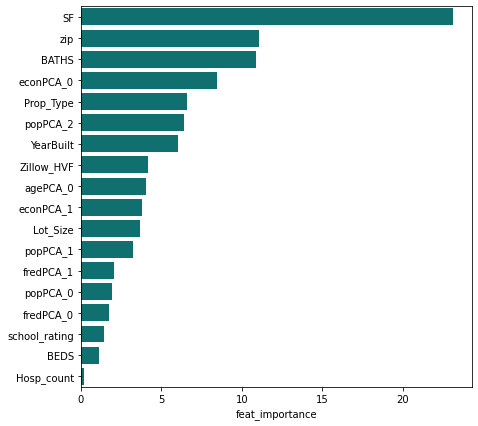

In [74]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");

# Simplify to single PCA model

In [75]:
all_feats = ['Population', 'Blacks_ratio', 'Hispanics_ratio', 'Asians_ratio', 
             'Indians_ratio', 'Others_ratio', 'Male_ratio', 'HouseholdsPerZipCode', 
             'MedianAge', 'over_65_ratio', 'IncomePerHousehold', 'NumberOfBusinesses', 
             'UE_rate', 'HPI', 'Demand_score', 'Supply_score', 'listviews_vs_US', 
             'med_days_on_mkt', 'nielson_rank']

In [80]:
pca = PCA(n_components=0.85)
pca.fit(data_scaled[all_feats])
print(f'population PCA explained: {np.round(pca.explained_variance_ratio_,3)}')
print(f'number of PCA columns: {len(pca.explained_variance_ratio_)}')
all_PCAs = pd.DataFrame(pca.fit_transform(data_scaled[all_feats]), 
                        columns=['PCA_'+str(n) for n in range(len(pca.explained_variance_ratio_))], 
                        index=zipdata.index)

population PCA explained: [0.473 0.177 0.106 0.058 0.046]
number of PCA columns: 5


In [81]:
RF = get_redfin_csv()
print(RF.shape)

----pulling Redfin data from Azure storage----
----Done----
(74717, 21)


In [82]:
RF = RF.merge(all_PCAs, how = 'left', left_on = 'zip', right_index=True)

In [83]:
RF.columns

Index(['Sale_Type', 'Sold_Date', 'Prop_Type', 'ADDRESS', 'CITY', 'State',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SF', 'Lot_Size', 'YearBuilt',
       'Days_on_Mkt', 'px_perSF', 'HOA_perMonth', 'STATUS', 'LATITUDE',
       'LONGITUDE', 'zip', 'Detached', 'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3',
       'PCA_4'],
      dtype='object')

In [84]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 12)
X_test rows: (19083, 12)


In [85]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.7573920029367731
train R2: 0.6443164788536447


In [86]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [87]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8667727390671047
Test R2: 0.8446055271997458


In [88]:
RF = RF.merge(zipdata[['school_rating','Zillow_HVF','Hosp_count']], how = 'left', left_on = 'zip', right_index=True)

In [89]:
#pd.set_option('display.max_rows', None)
zip_houses = RF.groupby('zip').agg('count')['PRICE'].to_dict()
RF['houses_perZIP'] = RF.zip.apply(lambda r: zip_houses[r])
RF = RF[RF.houses_perZIP>4]
# Use groupby to split the df into smaller dfs for each ZIP
groups = RF.groupby('zip')
dfs = [groups.get_group(x) for x in groups.groups]
# Use first df to initiate X_train, X_test, etc
for d in dfs[:1]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4','school_rating','Zillow_HVF','Hosp_count']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_train, X_test, y_train, y_test = train_test_split(feat, y, test_size=0.25)
# train_test_split each df then stack together
for d in dfs[1:]:
    feat = d[['Prop_Type','BEDS','BATHS','SF','Lot_Size','YearBuilt','zip',
              'PCA_0', 'PCA_1', 'PCA_2', 'PCA_3','PCA_4','school_rating','Zillow_HVF','Hosp_count']]
    feat.zip = feat.zip.astype('object')
    y = np.log10(d.PRICE)
    X_trainpiece, X_testpiece, y_trainpiece, y_testpiece = train_test_split(feat, y, test_size=0.25)
    X_train = X_train.append(X_trainpiece)
    X_test = X_test.append(X_testpiece)
    y_train = y_train.append(y_trainpiece)
    y_test = y_test.append(y_testpiece)
# Check rows
print(f'X_train rows: {X_train.shape}')
print(f'X_test rows: {X_test.shape}')

X_train rows: (54473, 15)
X_test rows: (19083, 15)


In [90]:
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum = pd.get_dummies(X_test, drop_first=True)
lm = LinearRegression()
lm.fit(X_train_dum, y_train)
print(f'train R2: {lm.score(X_train_dum, y_train)}')
print(f'train R2: {lm.score(X_test_dum, y_test)}')

train R2: 0.7521496450225066
train R2: 0.7450510358898367


In [91]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

le = LabelEncoder()
X_train_le.Prop_Type = le.fit_transform(X_train_le.Prop_Type)
X_test_le.Prop_Type = le.fit_transform(X_test_le.Prop_Type)
X_train_le.zip = le.fit_transform(X_train_le.zip)
X_test_le.zip = le.fit_transform(X_test_le.zip)

In [92]:
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train_le, y_train)
print(f'Train R2: {cat.score(X_train_le, y_train)}')
print(f'Test R2: {cat.score(X_test_le, y_test)}')

Train R2: 0.8737773909818538
Test R2: 0.8515443671206918


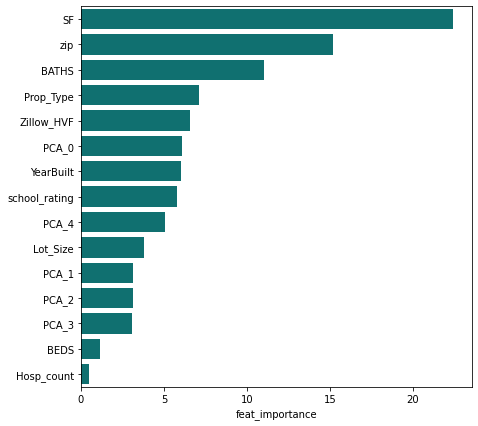

In [93]:
feat_importances = pd.DataFrame(cat.get_feature_importance(), index=X_train_le.columns, columns=['feat_importance'])
feat_importances = feat_importances.sort_values(by='feat_importance', ascending=False)

f, ax = plt.subplots(figsize=(7, 7))
sns.barplot(x='feat_importance', y=feat_importances.index, data=feat_importances, color="teal");